# 新冠疫情对于2020年第一季度供水量影响

 除夕前两周进入春运，选取除夕前一月到次年三月为比较时间段2019年12月24日到2020年3月31日一共98天， 同理选取2019年1月4日到2019年4月12日

In [39]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt

import pandas as pd
import datetime as dt

startday = dt.datetime(2019,11,24)
endday = dt.datetime(2020,3,31)
endday-startday


datetime.timedelta(days=128)

In [43]:
startday_lastyear = dt.datetime(2018,12,5)
endday_lastyear = startday_lastyear + dt.timedelta(days=128)
print(endday_lastyear)

2019-04-12 00:00:00


读取日供水总量，并选取上面两个时间段，分别做曲线

Text(0.5, 1.0, '日供水总量')

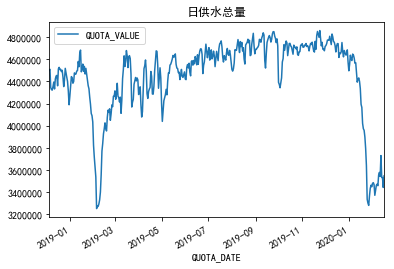

In [81]:
sup_water = pd.read_excel(r'c:/Users/XieJie/mypyworks/自来水数据/春节期间供水总量.xlsx')
sup_water = sup_water[['QUOTA_DATE','QUOTA_VALUE']].set_index('QUOTA_DATE')
sup_water.plot()
plt.title('日供水总量')

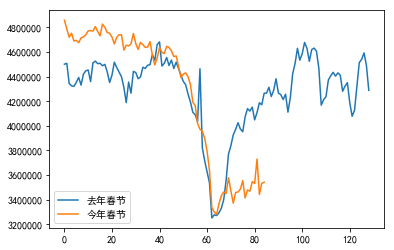

In [73]:
plt.plot(sup_water['2018-12-5':'2019-4-12'].values)
plt.plot(sup_water['2019-11-24':].values)
plt.legend(['去年春节','今年春节'])

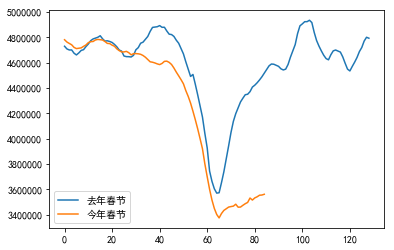

In [74]:
plt.plot(sup_water['2018-12-5':'2019-4-12']['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values*1.07)
plt.plot(sup_water['2019-11-24':]['QUOTA_VALUE'].rolling(window=7,min_periods=1, center=True).mean().values)
plt.legend(['去年春节','今年春节'])

1月23日武汉封城作为，疫情发生明显影响开始点，对1月23日前数据乘以系数，模拟今年供水水平。

对2月18到3月31日供水总量做一个时间序列预测，时间序列按照疫情影响结束2月29日为时间点。采用做一个短期时间序列预测。

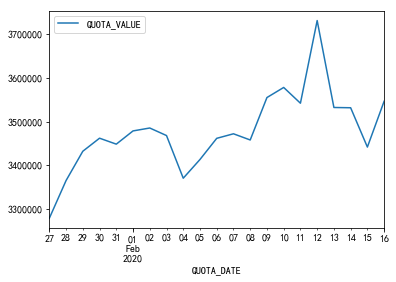

In [87]:
sup_water.sort_index()['2020-1-27':].plot()

In [ ]:
import statsmodels.api as sm


In [ ]:
模拟正常水量-预测水量即是影响量。